# Visualizing DJIA .csv File

In [223]:
# Import required libraries

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.dates as mdates
from wordcloud import WordCloud
import re
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image

### Load Input

In [224]:
# DJIA_table.csv has 1989 rows

df = pd.read_csv('./upload_DJIA_table.csv', delimiter=',')
df.dataframeName = 'DJIA_table.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1989 rows and 7 columns


In [225]:
df = df.sort_values(by=['Date'])
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [226]:
reddit_news = pd.read_csv('./RedditNews.csv', delimiter=',')
combined_news = pd.read_csv('./Combined_News_DJIA.csv', delimiter=',')

### Helper Functions

In [248]:
# Distribution graphs (histogram/bar graph) of column data

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    

In [228]:
# Correlation matrix

def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    numeric_columns = df.select_dtypes(include=[np.number])
    #df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = numeric_columns.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for DJIA', fontsize=15)
    plt.show()

In [229]:
# Scatter and density plots

def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis = 'columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [230]:
def plotClosingMovingPriceOverTime(df):
    plt.figure(figsize=(12, 6))
    df['30_day_MA'] = df['Close'].rolling(window=30).mean()
    plt.plot(df['Date'], df['Close'], label='Closing Price')
    plt.plot(df['Date'], df['30_day_MA'], label='30-Day Moving Average', color='orange')
    
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.title('DJIA Closing Price Over Time & 30-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.xticks(rotation=45)
    plt.legend()

    plt.show()

In [231]:
def plotBubbleChartMonthlyResampled(df):
    df.set_index('Date', inplace=True)

    monthly_df = df.resample('M').mean().reset_index()

    plt.figure(figsize=(12, 6))
    plt.scatter(monthly_df['Date'], monthly_df['Close'], s=monthly_df['Volume']/1000000, alpha=0.5)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.title('DJIA Monthly Average Trading Volume (in millions) vs Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Average Closing Price')
    plt.xticks(rotation=45)
    plt.show()

    df.reset_index(inplace=True)


In [232]:
def plotNewsWordCloud():
    words_to_exclude_reddit = ["say", "new"]
    words_to_exclude_combines = ["will", "say", "new"]

    reddit_all_text = " ".join(reddit_news['News'])
    reddit_news_text_processed = " ".join([word for word in reddit_all_text.split() if len(word) > 1 and word.lower() not in [item.lower() for item in words_to_exclude_reddit]])
    reddit_news_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reddit_news_text_processed)

    combined_all_text = ""

    for i in range(1, 6):
        column_name = f'Top{i}'
        combined_all_text += " ".join(combined_news[column_name].dropna())

    combined_news_text_processed = " ".join([word for word in reddit_all_text.split() if len(word) > 1 and word.lower() not in [item.lower() for item in words_to_exclude_combines]])
    combined_news_text_processed = re.sub(r"(b'|b\")", '', combined_news_text_processed)
    combined_news_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_news_text_processed)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(reddit_news_wordcloud, interpolation='bilinear')
    ax1.set_title('Reddit News Word Cloud')
    ax1.axis("off")

    ax2.imshow(combined_news_wordcloud, interpolation='bilinear')
    ax2.set_title('Combined News Word Cloud')
    ax2.axis("off")

    plt.show()

In [233]:
def plotRelativeVolumeHeatmap(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

    #Calculate the mean trading volume for each year
    yearly_mean_volume = df.groupby('Year')['Volume'].transform('mean')

    #Calculate the relative trading volume by dividing the actual volume by the yearly mean
    df['Relative_Volume'] = df['Volume']/yearly_mean_volume

    pivot_table = df.pivot_table(values='Relative_Volume', index='Month', columns='Year', aggfunc='mean')

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_table, cmap='inferno', annot=False, fmt=".2f", cbar_kws={'label': 'Relative Volume'})
    plt.gca().invert_yaxis()
    plt.title('Relative Yearly Trading Volume Heatmap')
    plt.xlabel('Year')
    plt.ylabel('Month')
    plt.show()


In [234]:
def plotCandlestick():
    pio.renderers.default = "browser"

    fig = go.Figure(data=[go.Candlestick(
                    x=df['Date'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])

    fig.update_layout(title='Candlestick Chart DJIA', xaxis_title='Date', yaxis_title='Price')
    fig.show()

### Visualizations

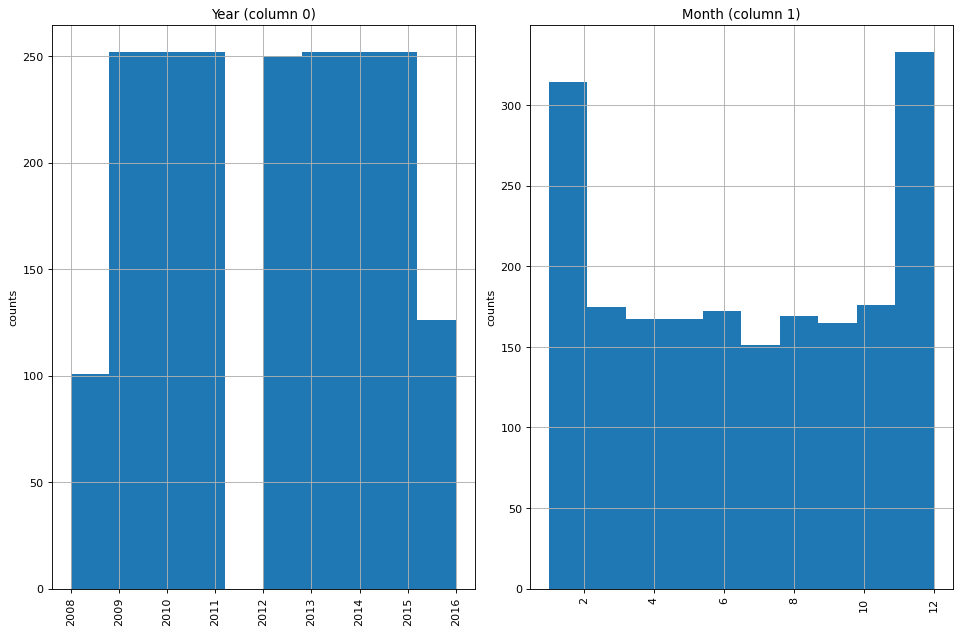

In [249]:
plotPerColumnDistribution(df, 2, 6)

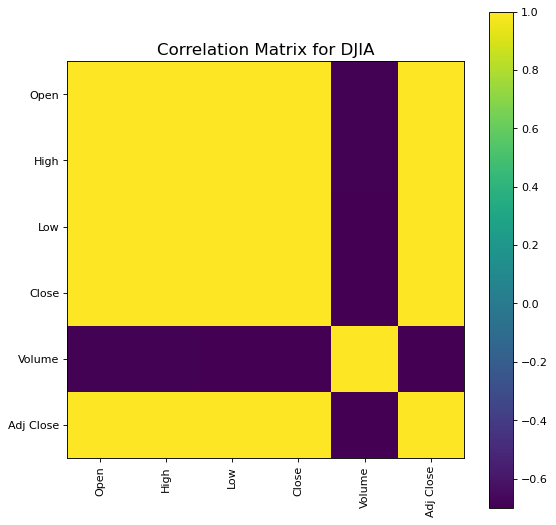

In [236]:
plotCorrelationMatrix(df, 8)

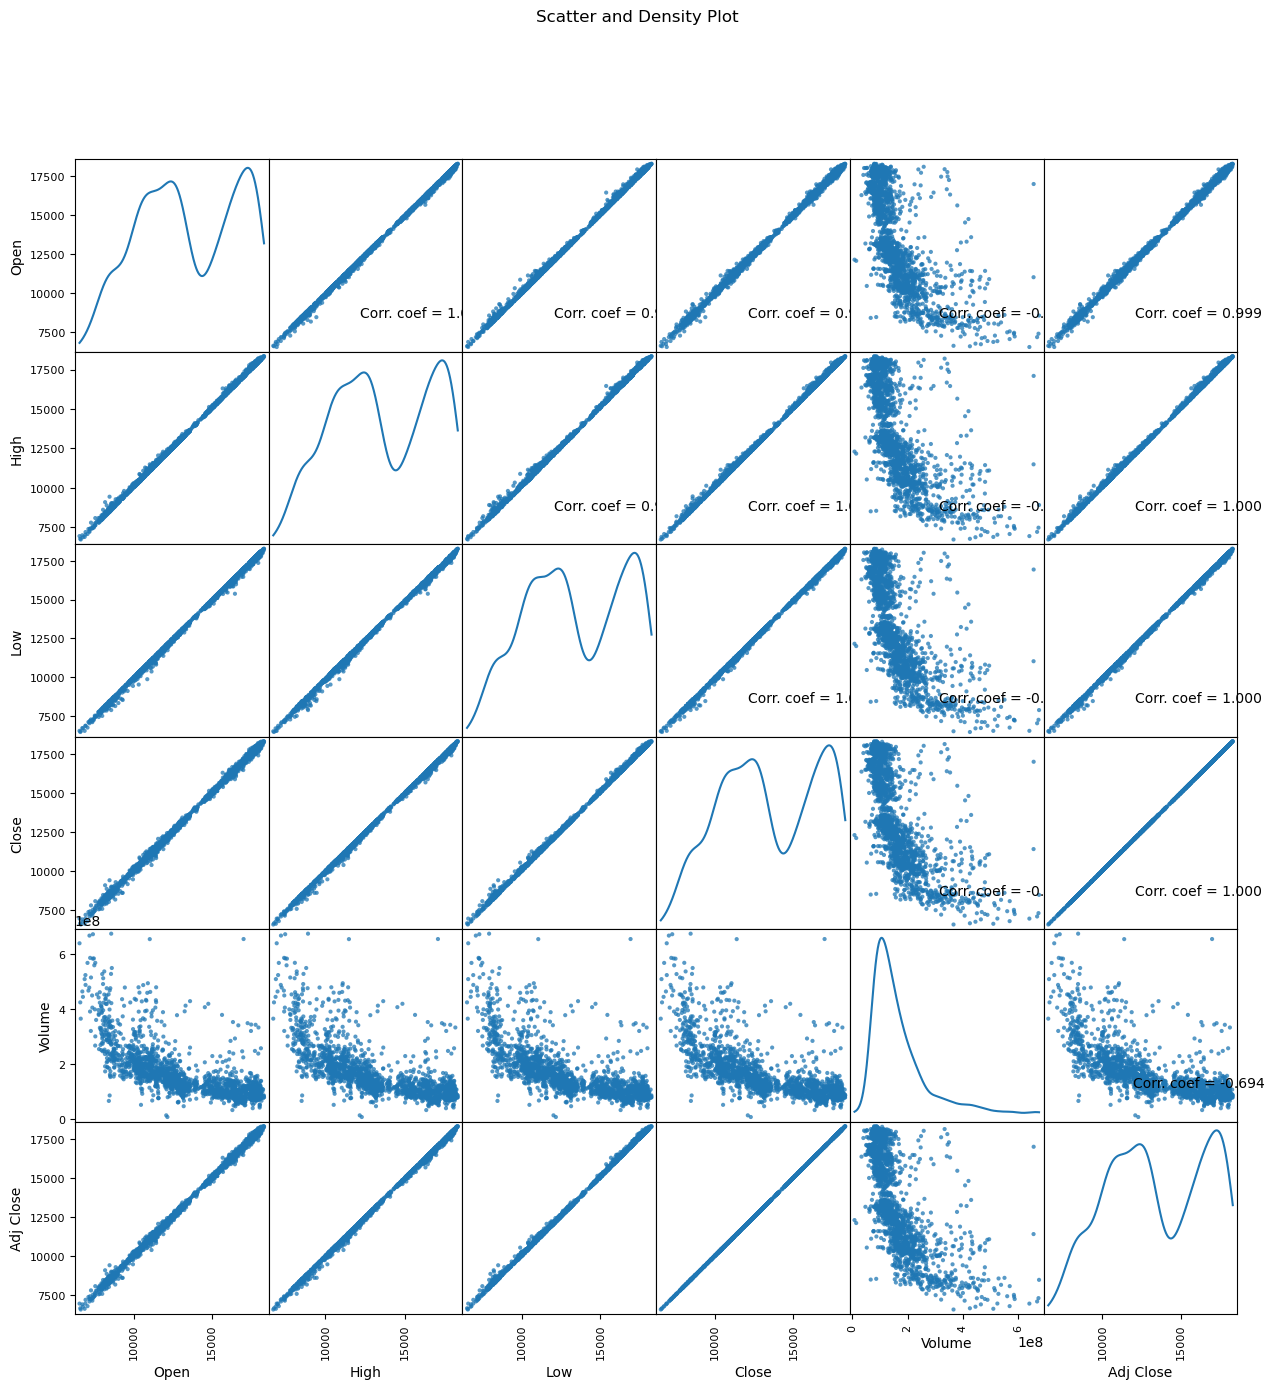

In [237]:
plotScatterMatrix(df, 15, 10)

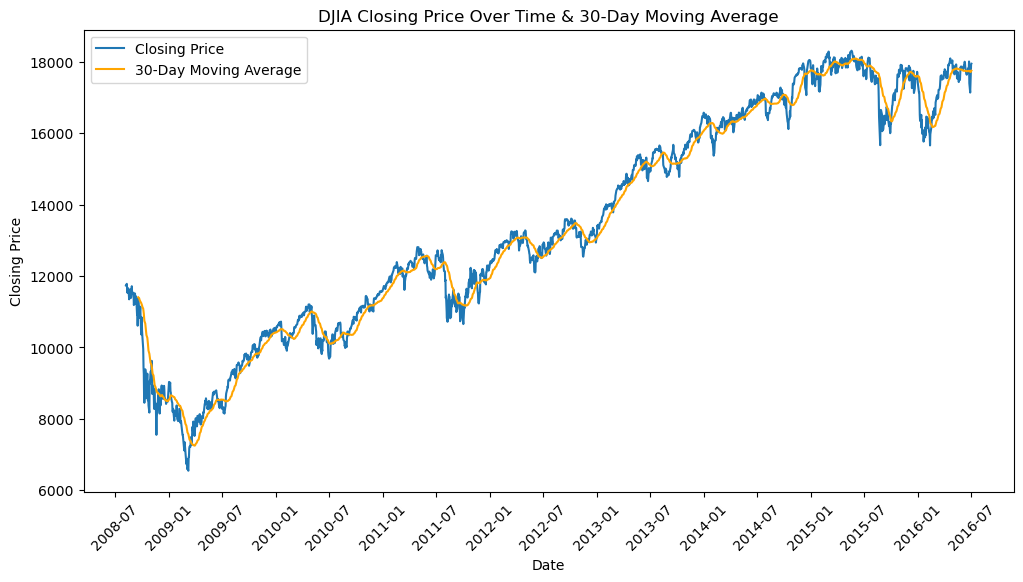

In [238]:
plotClosingMovingPriceOverTime(df)

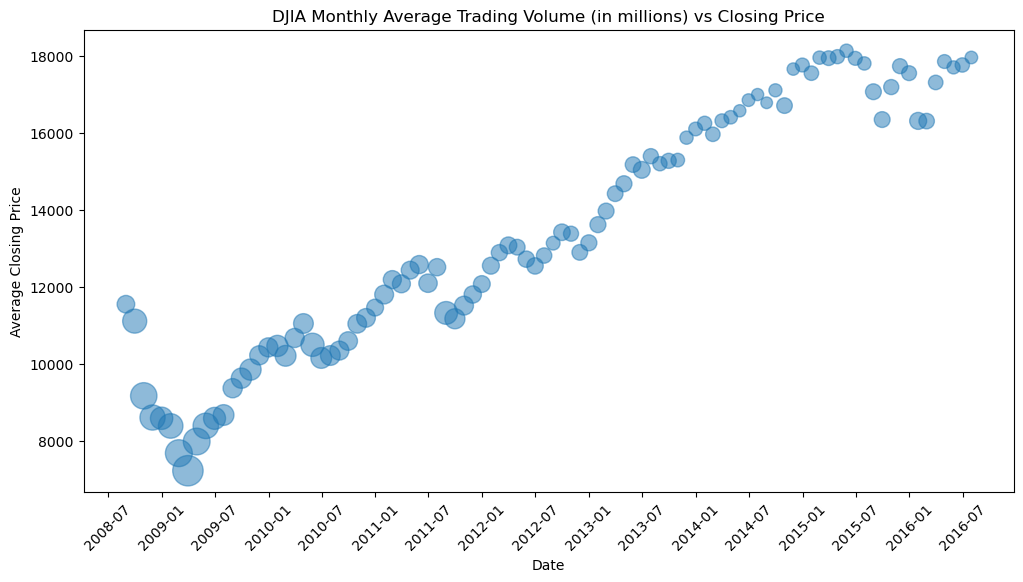

In [239]:
plotBubbleChartMonthlyResampled(df)

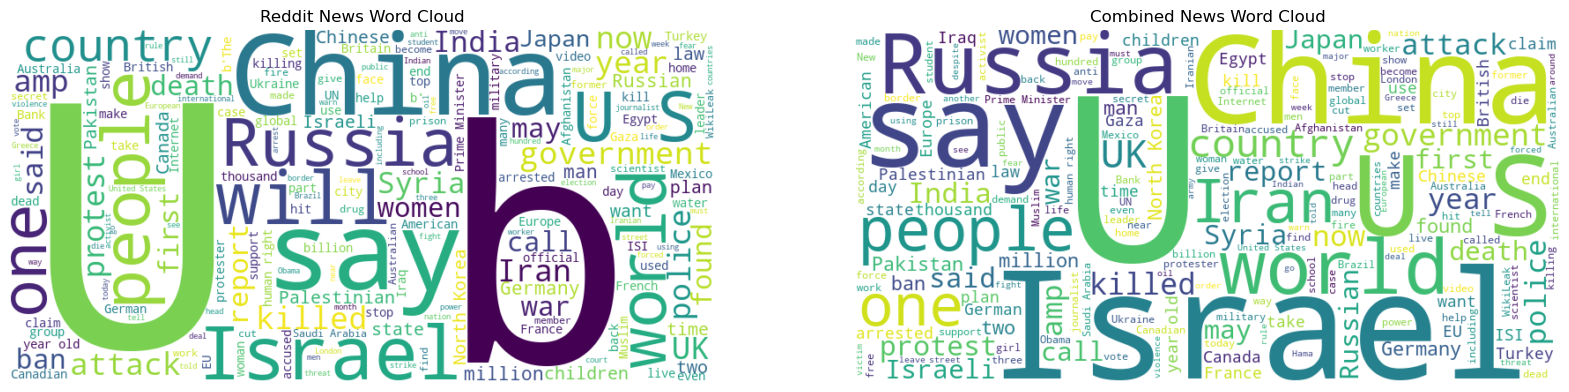

In [240]:
plotNewsWordCloud()

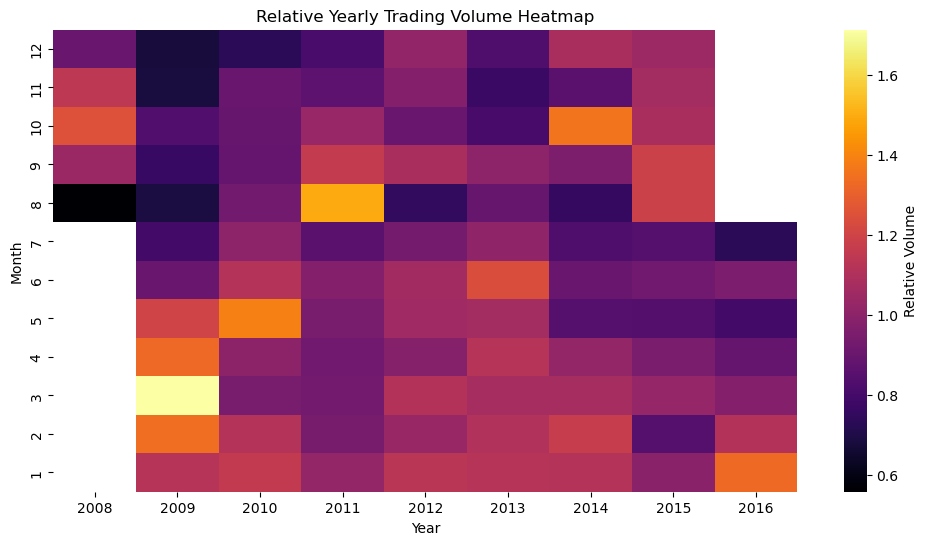

In [241]:
plotRelativeVolumeHeatmap(df)

/Users/miranyildirim/miniconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



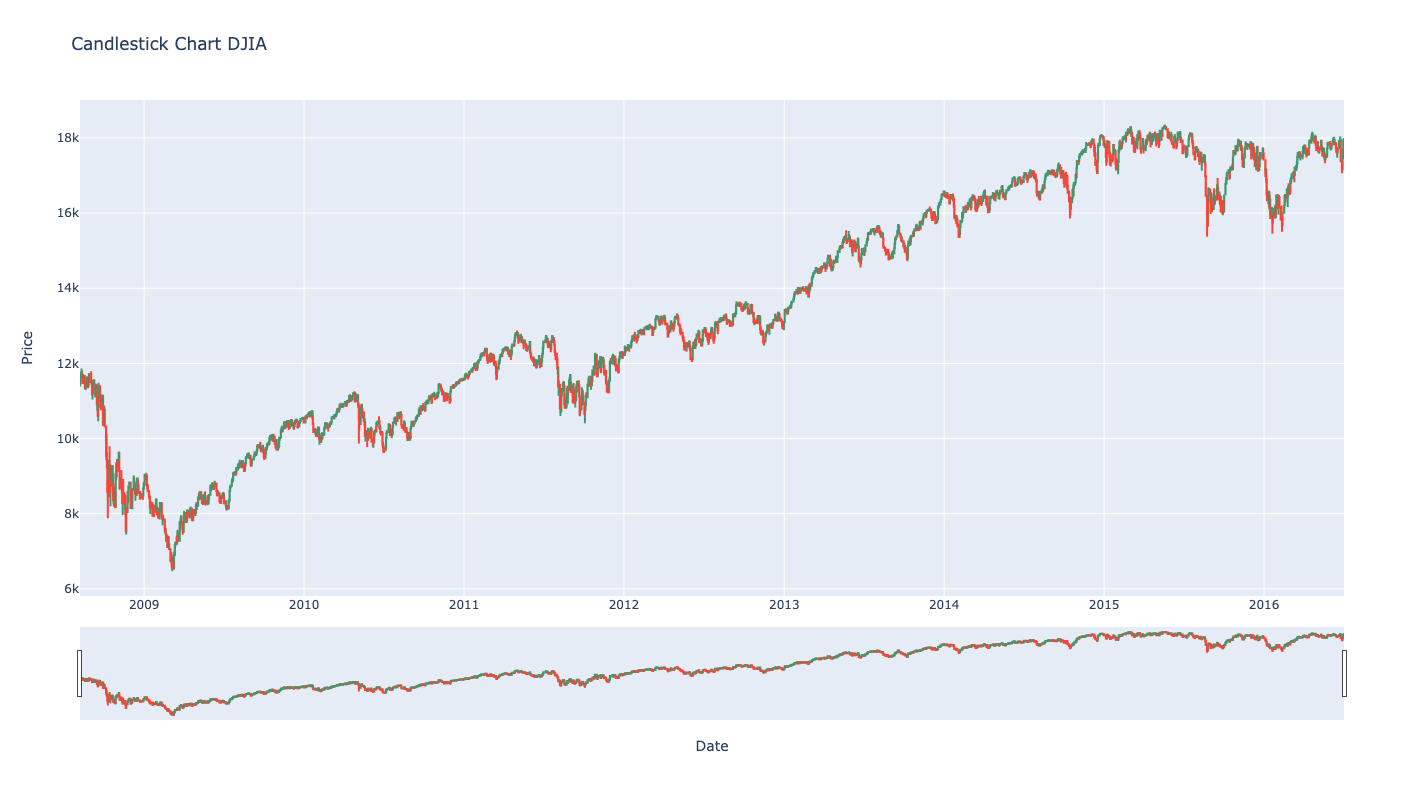

In [242]:
#Run this cell to get the interactive candlestick chart on your browse
plotCandlestick()

#This is how the chart looks like
image_path = 'candlestick.png'
Image(filename=image_path)